## Discretisation with Decision Trees


Discretisation with Decision Trees consists in using a decision tree to identify the optimal bins. When a decision tree makes a decision, it assigns an observation to one of n end leaves. Therefore, any decision tree will generate a discrete output, which values are the predictions at each of its n leaves.

How to do discretisation with trees?

- 1) Train a decision tree of limited depth (2, 3  or 4) using the variable we want to discretise and the target.
- 2) Replace the values by the output returned by the tree. 


### Advantages

- The output returned by the decision tree is monotonically related to the target.
- The tree end nodes, or bins in the discretised variable show decreased entropy: that is, the observations within each bin are more similar among themselves than to those of other bins.

### Limitations

- Prone over-fitting
- More importantly, some tuning of the tree parameters needed to obtain the optimal number of splits (e.g., tree depth, minimum number of samples in one partition, maximum number of partitions, and a minimum information gain). This it can be time consuming.

## In this demo

We will learn how to perform discretisation with decision trees using the Titanic dataset.

### Titanic dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score

In [2]:
# load the numerical variables of the Titanic Dataset

data = pd.read_csv('../Datasets/titanic.csv',
                   usecols = ['age', 'fare', 'survived'])


data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((916, 2), (393, 2))

The variables Age and Fare contain missing data, that I will fill by extracting a random sample of the variable.

In [4]:
def impute_na(data, variable):
    df = data.copy()
    
    # random sampling
    df[variable+'_random'] = df[variable]
    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(df[variable].isnull().sum(), random_state=0)
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample
    
    return df[variable+'_random']

In [5]:
# replace NA in both train and test sets

X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')

X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

### Age

In [6]:
X_train.head()

,age,fare
501,13.0,19.5000
588,4.0,23.0000
402,30.0,13.8583
1193,40.5,7.7250
686,22.0,7.7250


In [7]:
# example: build Classification tree using Age to predict Survived

tree_model = DecisionTreeClassifier(max_depth=3)

tree_model.fit(X_train['age'].to_frame(), y_train)

X_train['Age_tree'] = tree_model.predict_proba(X_train['age'].to_frame())[:,1]

X_train.head(10)

,age,fare,Age_tree
501,13.0,19.5000,0.857143
588,4.0,23.0000,0.509091
402,30.0,13.8583,0.398496
1193,40.5,7.7250,0.398496
686,22.0,7.7250,0.398496
971,39.0,7.8792,0.398496
117,30.0,56.9292,0.398496
540,2.0,26.0000,0.509091
294,49.0,110.8833,0.398496
261,35.0,26.2875,0.398496


In [8]:
# let's explore how many end points the tree created

X_train['Age_tree'].unique()

array([0.85714286, 0.50909091, 0.39849624, 0.31481481, 0.21428571,
       0.45454545, 0.29411765, 0.09090909])

A tree of depth 2, makes 2 splits, therefore generating 4 buckets, that is why we  see 4 different probabilities in the output above.

Text(0, 0.5, 'Survived')

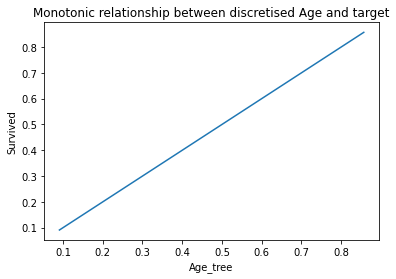

In [9]:
# monotonic relationship with target

pd.concat([X_train, y_train], axis=1).groupby(['Age_tree'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

<AxesSubplot:xlabel='Age_tree'>

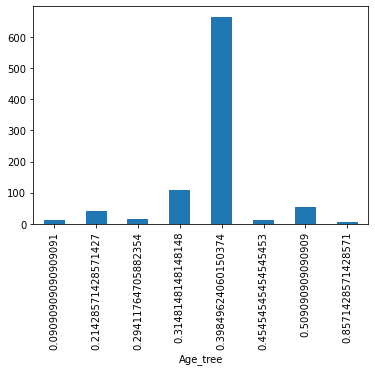

In [10]:
# number of passengers per probabilistic bucket / bin

X_train.groupby(['Age_tree'])['age'].count().plot.bar()

<AxesSubplot:xlabel='Age_tree'>

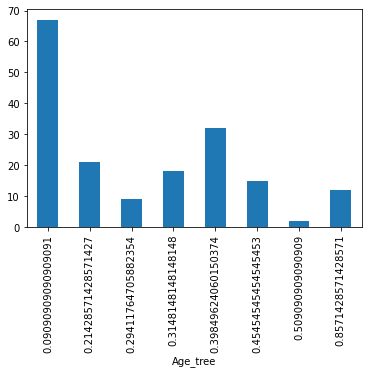

In [11]:
# median age within each bucket originated by the tree

X_train.groupby(['Age_tree'])['age'].median().plot.bar()

In [12]:
# let's see the Age limits buckets generated by the tree
# by capturing the minimum and maximum age per each probability bucket, 
# we get an idea of the bucket cut-offs

pd.concat( [X_train.groupby(['Age_tree'])['age'].min(),
            X_train.groupby(['Age_tree'])['age'].max()], axis=1)

,age,age
Age_tree,,
0.090909,65.0000,74.0
0.214286,21.0000,21.0
0.294118,9.0000,11.5
0.314815,16.0000,20.0
0.398496,22.0000,64.0
0.454545,14.0000,15.0
0.509091,0.1667,8.0
0.857143,12.0000,13.0


Thus, the decision tree generated the buckets: 65-74, 9-44, 45-64 and 0.7-8 and 0-16-0.16, with probabilities of survival of .0, .36, .45, .52 and .1 respectively.

### Tree visualisation

In [13]:
# we can go ahead and visualise the tree by saving the model to a file,
# and opening that file in the below indicated link

with open("tree_model.txt", "w") as f:
    f = export_graphviz(tree_model, out_file=f)

# go here to open the file: http://webgraphviz.com

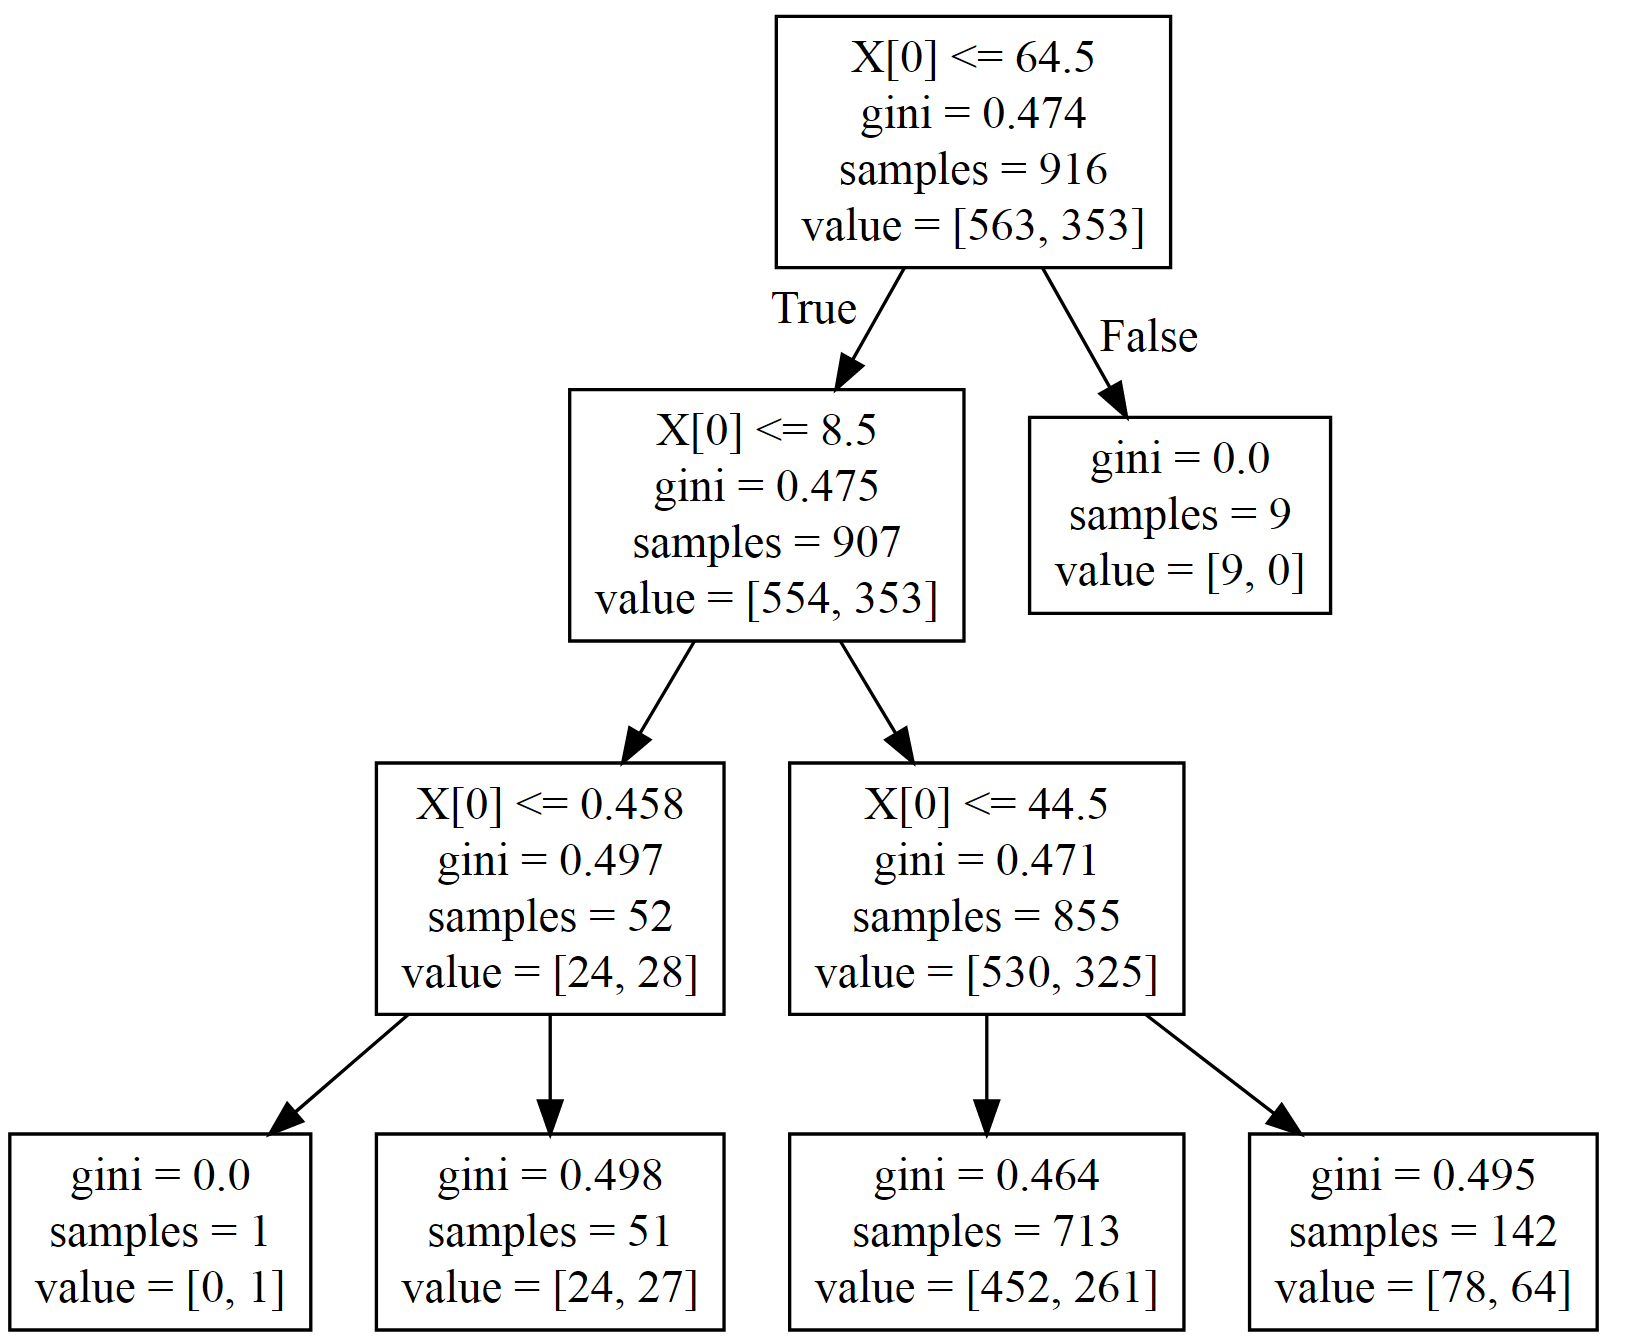

In [14]:
# this is what you should see if you do what is described in the previous cell

# I saved the image you should retrieve in the server above into a png, and then load
# it here to smooth the demo

# the  plot indicates  the age cut-offs at each node, and also the number of samples at each node, and 
# the gini

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "tree_visualisation.png"
Image(filename = PATH , width=1000, height=1000)

**Let's expand the tree results to the test set, and explore the monotonic relationship**

Text(0, 0.5, 'Survived')

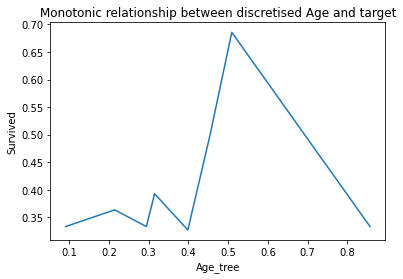

In [15]:
X_test['Age_tree'] = tree_model.predict_proba(X_test['age'].to_frame())[:,1]

# monotonic relationship with target

pd.concat([X_test, y_test], axis=1).groupby(['Age_tree'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

We can see that the monotonic relationship is not maintained in the test set, which probably indicates that the tree we build was over-fitting to the train set.

### Building the optimal decision tree

There are a number of parameters that we could optimise to obtain the best bin split using decision trees.

I will optimise the tree depth for this demonstration. But remember that we could also optimise the remaining parameters of the decision tree. 

Visit [sklearn website](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) to see which other parameters can be optimised.

In [16]:
# Build trees of different depths, and calculate the roc-auc of each tree
# choose the depth that generates the best roc-auc

score_ls = []  # here we store the roc auc
score_std_ls = []  # here we store the standard deviation of the roc_auc

for tree_depth in [1, 2, 3, 4]:

    # call the model
    tree_model = DecisionTreeClassifier(max_depth=tree_depth)

    # train the model using 3 fold cross validation

    scores = cross_val_score(
        tree_model, X_train['age'].to_frame(), y_train, cv=3, scoring='roc_auc')
    
    # save the parameters
    score_ls.append(np.mean(scores))
    score_std_ls.append(np.std(scores))

    
# capture the parameters in a dataframe
temp = pd.concat([pd.Series([1, 2, 3, 4]), pd.Series(
    score_ls), pd.Series(score_std_ls)], axis=1)

temp.columns = ['depth', 'roc_auc_mean', 'roc_auc_std']
temp

,depth,roc_auc_mean,roc_auc_std
0,1,0.481819,0.019323
1,2,0.505185,0.010830
2,3,0.506725,0.004183
3,4,0.521277,0.017416


We obtain the best roc-auc using depths of 2 (same value as depth 4 but smaller std). I will select depth of 2 to proceed.

### Transform the feature using tree

In [17]:
tree_model = DecisionTreeClassifier(max_depth=2)

tree_model.fit(X_train['age'].to_frame(), y_train)

X_train['Age_tree'] = tree_model.predict_proba(X_train['age'].to_frame())[:, 1]
X_test['Age_tree'] = tree_model.predict_proba(X_test['age'].to_frame())[:, 1]

Text(0, 0.5, 'Survived')

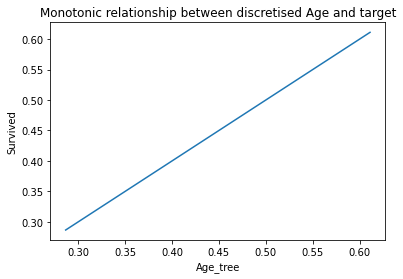

In [18]:
# monotonic relationship with target in train set

pd.concat([X_train, y_train], axis=1).groupby(['Age_tree'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Text(0, 0.5, 'Survived')

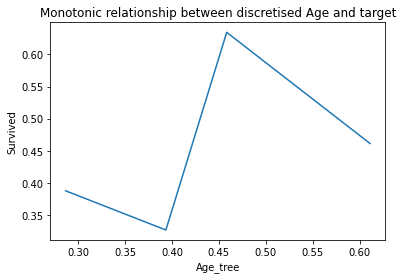

In [19]:
# and in the test set

X_test['Age_tree'] = tree_model.predict_proba(X_test['age'].to_frame())[:,1]

# monotonic relationship with target
pd.concat([X_test, y_test], axis=1).groupby(['Age_tree'])['survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')

Now the monotonic relationship is not totally maintained in the test. Probably because there are few samples in the upper buckets:

<AxesSubplot:xlabel='Age_tree'>

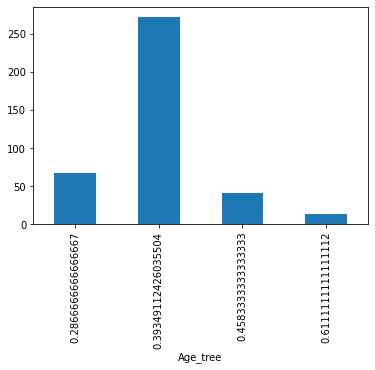

In [20]:
# median age within each bucket originated by the tree

X_test.groupby(['Age_tree'])['age'].count().plot.bar()

We could try and optimise the decision tree further to see if we can keep the monotonic relationship. Or alternatively, directly test the model performance with these engineered features and see if they add any value. 